In [1]:
import json
import pandas as pd
import torch
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from torch import nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pathlib import Path
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


batch_size = 8
json_file = 'drive/MyDrive/yelp_dataset/review_dataset.json'

In [2]:
def split_dataset(dataset, split_ratio=0.8):
    split_idx = int(len(dataset) * split_ratio)
    return dataset[:split_idx], dataset[split_idx:]

class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.encoder = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Linear(self.encoder.config.hidden_size, 5)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids, attention_mask=attention_mask)
        # take the [CLS] hidden state in the last layer
        pooled_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(pooled_output)

    def fit(self, train_data, epochs=4, batch_size=32, lr=2e-5):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        optimizer = Adam(self.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            self.train()
            total_loss = 0
            for i, batch in tqdm(enumerate(train_loader)):
                inputs = self.tokenizer(batch['text'], padding=True, truncation=True, return_tensors="pt")
                input_ids = inputs['input_ids'].to(self.device)
                attention_mask = inputs['attention_mask'].to(self.device)

                labels = batch['label'].to(torch.long).to(self.device)

                optimizer.zero_grad()
                outputs = self(input_ids, attention_mask)
                loss = loss_fn(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                if i % 50 == 0:
                    print(f"Step {i+1}, Loss {loss.item()}")

                if i > 5000 / batch_size:
                    break

            print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

    def predict_proba(self, texts):
        self.eval()
        inputs = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = self(inputs['input_ids'].to(self.device), inputs['attention_mask'].to(self.device))
            predictions = torch.softmax(outputs, dim=1)
        return predictions

    def predict(self, texts):
        pred = self.predict_proba(texts)
        # return labels with highest probability
        return torch.argmax(pred, dim=1)

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))


class TextDataset(Dataset):
    def __init__(self, input):
         self.data = input

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['text']
        label = item['stars'] - 1   # handle off-by-1 issue
        return {"text": text, "label": label}

def load_data(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    return data


data = load_data(json_file)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = TextDataset(train_data)
test_dataset = TextDataset(test_data)

model = BERTClassifier()
model.fit(train_dataset, epochs=1, batch_size=batch_size, lr=2e-5)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
1it [00:00,  1.01it/s]

Step 1, Loss 1.4924676418304443


51it [00:23,  2.40it/s]

Step 51, Loss 0.9923719167709351


101it [00:46,  3.06it/s]

Step 101, Loss 0.5047799348831177


151it [01:07,  2.30it/s]

Step 151, Loss 0.8505437970161438


202it [01:28,  2.48it/s]

Step 201, Loss 1.6367942094802856


251it [01:53,  1.93it/s]

Step 251, Loss 0.7616274952888489


301it [02:14,  2.20it/s]

Step 301, Loss 1.1910796165466309


351it [02:39,  1.88it/s]

Step 351, Loss 0.3619362711906433


401it [03:03,  2.70it/s]

Step 401, Loss 0.31151968240737915


451it [03:28,  2.41it/s]

Step 451, Loss 0.5633195638656616


501it [03:50,  2.32it/s]

Step 501, Loss 0.8272767663002014


551it [04:14,  2.11it/s]

Step 551, Loss 0.5670033097267151


601it [04:36,  2.87it/s]

Step 601, Loss 0.49072813987731934


626it [04:49,  2.16it/s]

Epoch 1, Loss: 0.005597111673796493


In [5]:
!nvidia-smi

Mon Apr 22 01:35:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              31W /  70W |   7563MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

63it [00:10,  6.29it/s]


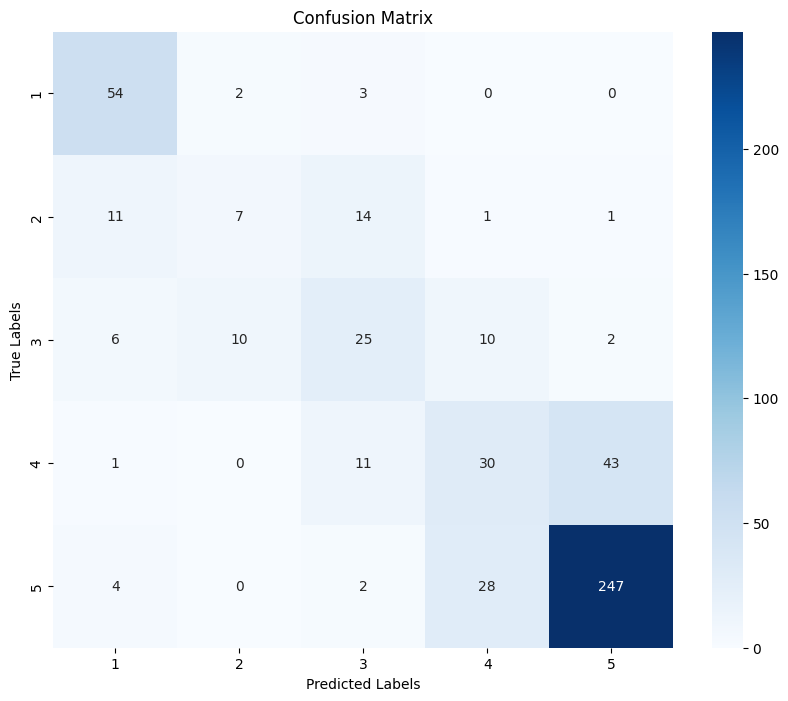

     Metric     Value
0  Accuracy  0.708984
1   ROC AUC  0.739528
              precision    recall  f1-score   support

     Class 1       0.71      0.92      0.80        59
     Class 2       0.37      0.21      0.26        34
     Class 3       0.45      0.47      0.46        53
     Class 4       0.43      0.35      0.39        85
     Class 5       0.84      0.88      0.86       281

    accuracy                           0.71       512
   macro avg       0.56      0.56      0.56       512
weighted avg       0.69      0.71      0.69       512



In [20]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
all_preds = []
all_labels = []
all_preds_prob = []
model.eval()
for i, batch in tqdm(enumerate(test_loader)):
    texts = batch['text']
    labels = batch['label'].numpy()

    inputs = model.tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(inputs['input_ids'].to(model.device), inputs['attention_mask'].to(model.device))
        predictions = torch.softmax(outputs, dim=1)
    preds = torch.argmax(predictions, dim=1).detach().cpu().numpy()
    all_preds_prob.extend(predictions.detach().cpu().numpy())
    all_preds.extend(preds)
    all_labels.extend(labels)

    if i > 500 / batch_size:
        break

all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3, 4])
all_preds_bin = label_binarize(all_preds, classes=[0, 1, 2, 3, 4])


accuracy = accuracy_score(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
cm = confusion_matrix(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels_bin, all_preds_bin, multi_class='ovr')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

performance_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC AUC'],
    'Value': [accuracy, roc_auc]
})
print(performance_df)

print(class_report)

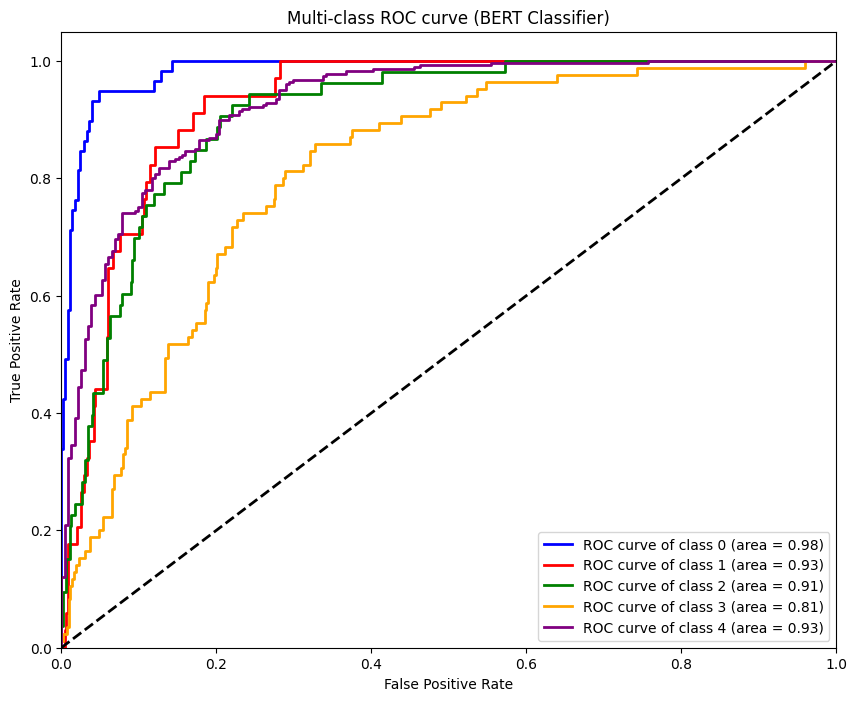

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

n_classes = 5
fpr = dict()
tpr = dict()
roc_auc = dict()
all_preds_prob = np.array(all_preds_prob)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve (BERT Classifier)')
plt.legend(loc="lower right")
plt.show()